In [61]:
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
words = open('../data/names.txt', 'r').read().splitlines()

In [63]:
# vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [64]:
# dataset
block_size = 8


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [94]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            dim = 0
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)

        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, input_size, emb_size):
        self.C = torch.randn((input_size, emb_size))

    def __call__(self, x):
        self.out = self.C[x]

        return self.out

    def parameters(self):
        return [self.C]


class Flatten:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1, x.shape[2] * self.n)
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)

        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x

        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [95]:
torch.manual_seed(42)

In [105]:
class WaveNet:
    def __init__(self, vocab_size, emb_size, hidden_size):
        self.model = Sequential([
            Embedding(vocab_size, emb_size),
            Flatten(2),
            Linear(emb_size * 2, hidden_size, bias=False),
            BatchNorm1d(hidden_size, momentum=0.001),
            Tanh(),
            Flatten(2),
            Linear(hidden_size * 2, hidden_size, bias=False),
            BatchNorm1d(hidden_size, momentum=0.001),
            Tanh(),
            Flatten(2),
            Linear(hidden_size * 2, hidden_size, bias=False),
            BatchNorm1d(hidden_size, momentum=0.001),
            Tanh(),
            Linear(hidden_size, vocab_size),
        ])

    def __call__(self, x):
        self.out = self.model(x)

        return self.out

    def parameters(self):
        return self.model.parameters()

    def train(self):
        self.model.layers[3].training = True
        self.model.layers[7].training = True
        self.model.layers[11].training = True

    def eval(self):
        self.model.layers[3].training = False
        self.model.layers[7].training = False
        self.model.layers[11].training = False


In [106]:
model = WaveNet(len(stoi), 24, 128)
for p in model.parameters():
    p.requires_grad = True
print(sum(p.nelement() for p in model.parameters()))

76579


In [98]:
for layer in model.model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

In [107]:
# Training
max_steps = int(3e5)
batch_size = 32
lossi = []
for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    x = model(X_batch)

    # Loss
    loss = F.cross_entropy(x, Y_batch)

    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # Update
    lr = 1e-1 if i < 2e5 else 1e-2
    for p in model.parameters():
        p.data += -lr * p.grad

    # Track stats
    if (i + 1) % 1e4 == 0:
        print(f"Epoch {i + 1}/{max_steps}: loss={loss.item():.4f}")
    lossi.append(loss.log10().item())


Epoch 10000/300000: loss=2.4626
Epoch 20000/300000: loss=1.8382
Epoch 30000/300000: loss=1.8789
Epoch 40000/300000: loss=2.2086
Epoch 50000/300000: loss=2.0569
Epoch 60000/300000: loss=1.4002
Epoch 70000/300000: loss=1.5364
Epoch 80000/300000: loss=1.9172
Epoch 90000/300000: loss=1.8244
Epoch 100000/300000: loss=2.4498
Epoch 110000/300000: loss=1.9773
Epoch 120000/300000: loss=1.7523
Epoch 130000/300000: loss=2.2882
Epoch 140000/300000: loss=1.8700
Epoch 150000/300000: loss=1.7824
Epoch 160000/300000: loss=1.6988
Epoch 170000/300000: loss=1.8541
Epoch 180000/300000: loss=1.9929
Epoch 190000/300000: loss=1.7820
Epoch 200000/300000: loss=1.6353
Epoch 210000/300000: loss=1.3497
Epoch 220000/300000: loss=1.8920
Epoch 230000/300000: loss=1.6939
Epoch 240000/300000: loss=1.7575
Epoch 250000/300000: loss=1.6381
Epoch 260000/300000: loss=1.5577
Epoch 270000/300000: loss=1.8223
Epoch 280000/300000: loss=1.8518
Epoch 290000/300000: loss=1.5323
Epoch 300000/300000: loss=1.6832


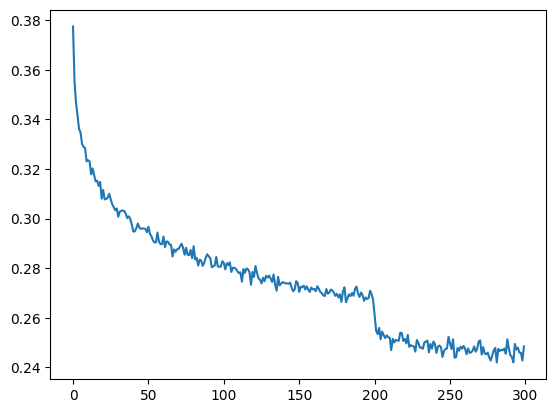

In [108]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [109]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)

    print(f"{split}: {loss.item()}")


split_loss('train')
split_loss('val')

train: 1.7340906858444214
val: 1.9950929880142212


In [110]:
# Sample from the model
with torch.no_grad():
    model.eval()
    for _ in range(10):
        out = []
        context = [0] * block_size
        while True:
            x = torch.tensor([context])
            logits = model(x)
            probs = F.softmax(logits, dim=1)

            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itos[i] for i in out[:-1]))

    model.train()

issiana
rahmara
mcbya
zeely
aadlyn
kalond
nyara
huber
briott
emmara
